# Logistic Regression Baseline

This notebook investigates multi-omics classification of TCGA BRCA tumors into PAM50 subtypes using regularized multinomial logistic regression. We first harmonize mRNA, DNA methylation, and RPPA data by intersecting patients and extracting consistent PAM50 labels, then explore each view with per-feature ANOVA and variance. Two feature-selection strategies are compared: (i) ANOVA eta^2-score ranking and (ii) simple variance-based ranking, applied either in an early integration setting (concatenated features with a single classifier) or in a late integration setting (view-specific classifiers whose probabilities are combined). For each model we estimate cross-validated performance (mean ± std of balanced accuracy) and report final test-set metrics with confussion matrices, allowing a systematic comparison of integration and feature-selection strategies across views.

In [2]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from palettable import wesanderson as wes

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    balanced_accuracy_score,
    roc_auc_score,
    f1_score,
)
from sklearn.base import clone

# our utilities
from utils.omic_helpers import *

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set(style="whitegrid")


### Load data

In [4]:
data_dir = "./../data/TCGA-BRCA/"
modalities = ["mRNA", "DNAm", "RPPA"]

data = {}
for omic in modalities:
    with open(f"{data_dir}{omic}.pkl", "rb") as f:
        data[omic] = pickle.load(f)

for omic in modalities:
    print(
        omic,
        "expr shape:",
        data[omic]["expr"].shape,
        "| meta shape:",
        data[omic]["meta"].shape,
    )


FileNotFoundError: [Errno 2] No such file or directory: './../data/TCGA-BRCA/mRNA.pkl'

### Patient intersection across views and class imbalance

In [6]:
idx_mrna = set(data["mRNA"]["expr"].index)
idx_meth = set(data["DNAm"]["expr"].index)
idx_prot = set(data["RPPA"]["expr"].index)

patients_intersection = sorted(list(idx_mrna & idx_meth & idx_prot))
print(f"Expr intersection size: {len(patients_intersection)}")


Expr intersection size: 401


#### For report

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted

set_rna  = set(data["mRNA"]["expr"].index)
set_dna  = set(data["DNAm"]["expr"].index)
set_rppa = set(data["RPPA"]["expr"].index)

plt.figure(figsize=(5, 5))
v = venn3_unweighted(
    [set_rna, set_dna, set_rppa],
    set_labels=("mRNA", "DNA methylation", "RPPA")
)

plt.title("Patient overlap across omic views")
plt.tight_layout()
plt.savefig("venn_omics.pdf")   # or "venn_omics.png"
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

omics   = ["mRNA", "DNAm", "RPPA"]
classes = ["Basal", "Her2", "LumA", "LumB"]

# replace with your true counts per omic and class
# rows: omics, columns: classes (Basal, Her2, LumA, LumB)
counts = np.array([
    [75,  42, 278, 105],  # mRNA
    [86,  29, 276, 109],  # DNAm
    [90,  39, 275,  96],  # RPPA
])

proportions = counts / counts.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(5, 4))

bottom = np.zeros(len(omics))
for i, cls in enumerate(classes):
    ax.bar(omics, proportions[:, i], bottom=bottom, label=cls)
    bottom += proportions[:, i]

ax.set_ylabel("Proportion of samples")
ax.set_ylim(0, 1)
ax.set_title("Class distribution per omic")
ax.legend(title="PAM50 subtype", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("class_dist_stacked.pdf")   # for LaTeX
plt.show()


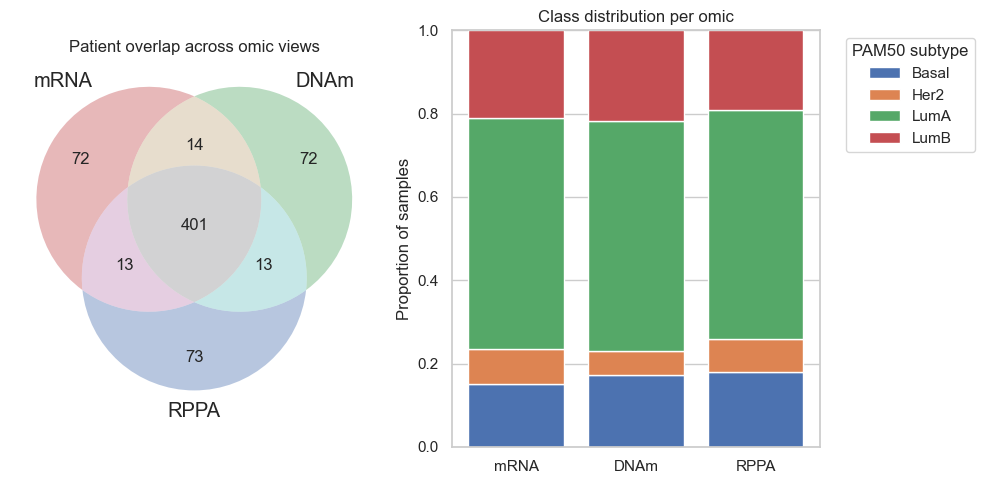

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# --------------------- Venn data ---------------------
set_rna  = set(data["mRNA"]["expr"].index)
set_dna  = set(data["DNAm"]["expr"].index)
set_rppa = set(data["RPPA"]["expr"].index)

# Compute counts for each of the 7 Venn regions
only_rna   = len(set_rna  - set_dna  - set_rppa)
only_dna   = len(set_dna  - set_rna  - set_rppa)
only_rppa  = len(set_rppa - set_rna  - set_dna)
rna_dna    = len((set_rna & set_dna)  - set_rppa)
rna_rppa   = len((set_rna & set_rppa) - set_dna)
dna_rppa   = len((set_dna & set_rppa) - set_rna)
all_three  = len(set_rna & set_dna & set_rppa)

region_counts = (
    only_rna,      # 100
    only_dna,      # 010
    rna_dna,       # 110
    only_rppa,     # 001
    rna_rppa,      # 101
    dna_rppa,      # 011
    all_three      # 111
)

# ---------------- stacked bar data -------------------
omics   = ["mRNA", "DNAm", "RPPA"]
classes = ["Basal", "Her2", "LumA", "LumB"]

counts = np.array([
    [75,  42, 278, 105],  # mRNA
    [86,  29, 276, 109],  # DNAm
    [90,  39, 275,  96],  # RPPA
])

proportions = counts / counts.sum(axis=1, keepdims=True)

# ---------------- combined figure --------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# (a) Venn diagram – same look as venn3_unweighted
# use equal subset sizes for shapes, then overwrite labels with true counts
v = venn3(
    subsets=(1, 1, 1, 1, 1, 1, 1),   # equal areas -> "unweighted"
    set_labels=("mRNA", "DNAm", "RPPA"),
    ax=ax1
)

for subset_id, count in zip(
    ('100', '010', '110', '001', '101', '011', '111'),
    region_counts
):
    label = v.get_label_by_id(subset_id)
    if label is not None:
        label.set_text(str(count))

ax1.set_title("Patient overlap across omic views")

# (b) Stacked bar – exactly your original code, just using ax2
bottom = np.zeros(len(omics))
for i, cls in enumerate(classes):
    ax2.bar(omics, proportions[:, i], bottom=bottom, label=cls)
    bottom += proportions[:, i]

ax2.set_ylabel("Proportion of samples")
ax2.set_ylim(0, 1)
ax2.set_title("Class distribution per omic")
ax2.legend(title="PAM50 subtype", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig("venn_omics_and_class_dist_side_by_side.pdf", bbox_inches="tight")
plt.show()


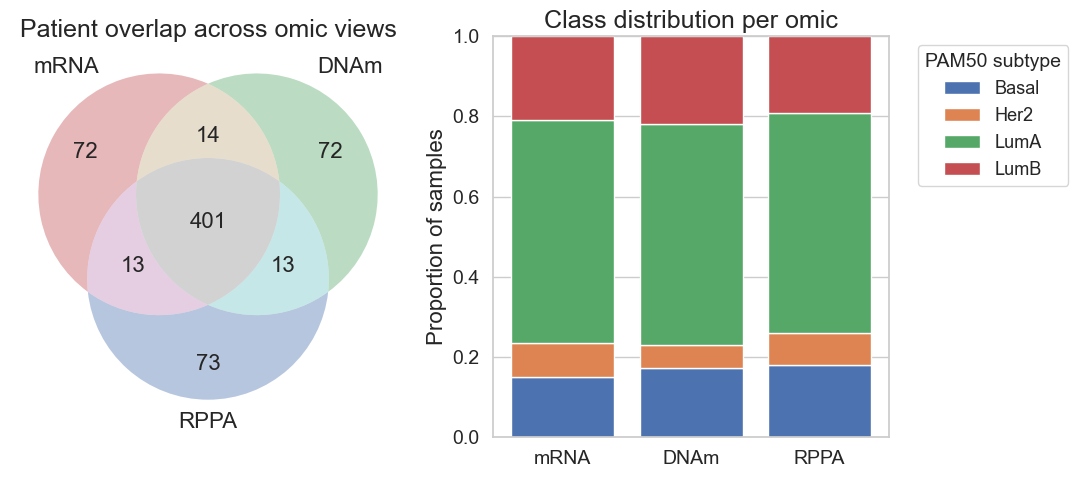

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# ---------- GLOBAL FONT SIZE ----------
plt.rcParams.update({"font.size": 14})  # base font bigger for everything

# --------------------- Venn data ---------------------
set_rna  = set(data["mRNA"]["expr"].index)
set_dna  = set(data["DNAm"]["expr"].index)
set_rppa = set(data["RPPA"]["expr"].index)

only_rna   = len(set_rna  - set_dna  - set_rppa)
only_dna   = len(set_dna  - set_rna  - set_rppa)
only_rppa  = len(set_rppa - set_rna  - set_dna)
rna_dna    = len((set_rna & set_dna)  - set_rppa)
rna_rppa   = len((set_rna & set_rppa) - set_dna)
dna_rppa   = len((set_dna & set_rppa) - set_rna)
all_three  = len(set_rna & set_dna & set_rppa)

region_counts = (
    only_rna,      # 100
    only_dna,      # 010
    rna_dna,       # 110
    only_rppa,     # 001
    rna_rppa,      # 101
    dna_rppa,      # 011
    all_three      # 111
)

# ---------------- stacked bar data -------------------
omics   = ["mRNA", "DNAm", "RPPA"]
classes = ["Basal", "Her2", "LumA", "LumB"]

counts = np.array([
    [75,  42, 278, 105],  # mRNA
    [86,  29, 276, 109],  # DNAm
    [90,  39, 275,  96],  # RPPA
])

proportions = counts / counts.sum(axis=1, keepdims=True)

# ---------------- combined figure --------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))  # a bit wider

# (a) Venn diagram
v = venn3(
    subsets=(1, 1, 1, 1, 1, 1, 1),
    set_labels=("mRNA", "DNAm", "RPPA"),
    ax=ax1
)

# make Venn region labels larger
for subset_id, count in zip(
    ('100', '010', '110', '001', '101', '011', '111'),
    region_counts
):
    label = v.get_label_by_id(subset_id)
    if label is not None:
        label.set_text(str(count))
        label.set_fontsize(16)

# make set labels larger
for lbl in v.set_labels:
    if lbl is not None:
        lbl.set_fontsize(16)

ax1.set_title("Patient overlap across omic views", fontsize=18)

# (b) Stacked bar
bottom = np.zeros(len(omics))
for i, cls in enumerate(classes):
    ax2.bar(omics, proportions[:, i], bottom=bottom, label=cls)
    bottom += proportions[:, i]

ax2.set_ylabel("Proportion of samples", fontsize=16)
ax2.set_ylim(0, 1)
ax2.set_title("Class distribution per omic", fontsize=18)

# bigger tick labels
ax2.tick_params(axis="both", labelsize=14)

# bigger legend text + title
leg = ax2.legend(
    title="PAM50 subtype",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=13,
    title_fontsize=14,
)

plt.tight_layout()
plt.savefig("venn_omics_and_class_dist_side_by_side1_bigfonts.pdf",
            bbox_inches="tight")
plt.show()


### PAM50 labels

In [7]:
pam_mrna = get_pam50(data, "mRNA")
pam_meth = get_pam50(data, "DNAm")
pam_prot = get_pam50(data, "RPPA")

pam_df = pd.concat([pam_mrna, pam_meth, pam_prot], axis=1)
pam_df = pam_df.reindex(patients_intersection)

pam50 = pam_df.bfill(axis=1).iloc[:, 0]
conflict_mask = pam_df.nunique(axis=1, dropna=True) > 1
n_conflicts = int(conflict_mask.sum())
if n_conflicts:
    print(
        f"Warning: {n_conflicts} patients have conflicting PAM50 labels "
        "(keeping mRNA > DNAm > RPPA)."
    )

pam50 = pam50.dropna()
patients = pam50.index.tolist()
print(f"Patients with PAM50 on expr-intersection: {len(patients)}")


Patients with PAM50 on expr-intersection: 401


### Building dataframes and label encoding

In [8]:
X_mrna = data["mRNA"]["expr"].loc[patients].values
X_meth = data["DNAm"]["expr"].loc[patients].values
X_prot = data["RPPA"]["expr"].loc[patients].values

y_str = pam50.astype(str).values

le = LabelEncoder()
y = le.fit_transform(y_str)
class_names = list(le.classes_)
print("PAM50 classes:", class_names)
print("Class counts:", np.bincount(y))

PAM50 classes: ['Basal', 'Her2', 'LumA', 'LumB']
Class counts: [ 61  28 230  82]


### Train/test split & per-view matrices

In [9]:
X_concat = np.hstack([X_mrna, X_meth, X_prot])
idx_all = np.arange(len(y))

idx_tr, idx_te = train_test_split(
    idx_all,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE,
)

Xtr_c, Xte_c = X_concat[idx_tr], X_concat[idx_te]
Xtr_m, Xte_m = X_mrna[idx_tr], X_mrna[idx_te]
Xtr_d, Xte_d = X_meth[idx_tr], X_meth[idx_te]
Xtr_p, Xte_p = X_prot[idx_tr], X_prot[idx_te]
y_tr, y_te = y[idx_tr], y[idx_te]

print("Train size:", len(y_tr), "Test size:", len(y_te))

Train size: 320 Test size: 81


### Per-feature ANOVA/Variance per view 

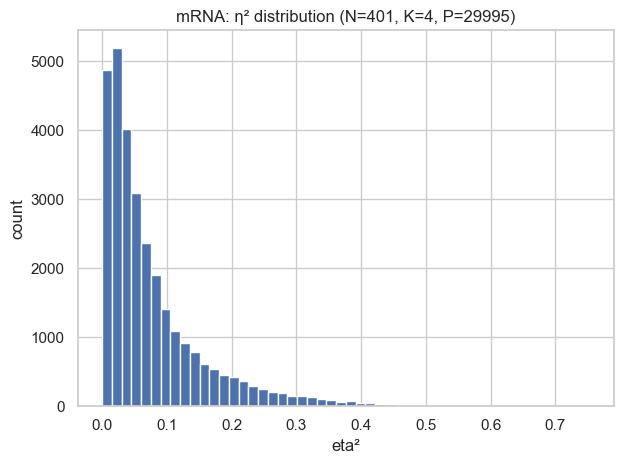

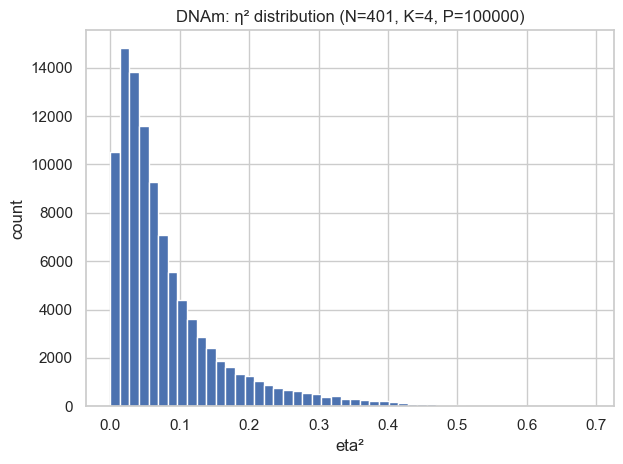

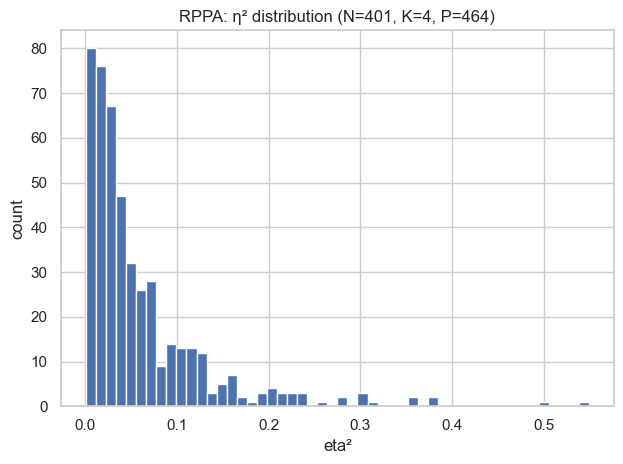

Features with eta2 > 0.2: 2623 8699 25


In [10]:
anova_mrna = per_feature_anova_np(X_mrna, y, "mRNA", plot=True)
anova_meth = per_feature_anova_np(X_meth, y, "DNAm", plot=True)
anova_prot = per_feature_anova_np(X_prot, y, "RPPA", plot=True)

K1 = (anova_mrna["eta2"] > 0.2).sum()
K2 = (anova_meth["eta2"] > 0.2).sum()
K3 = (anova_prot["eta2"] > 0.2).sum()
print("Features with eta2 > 0.2:", K1, K2, K3)

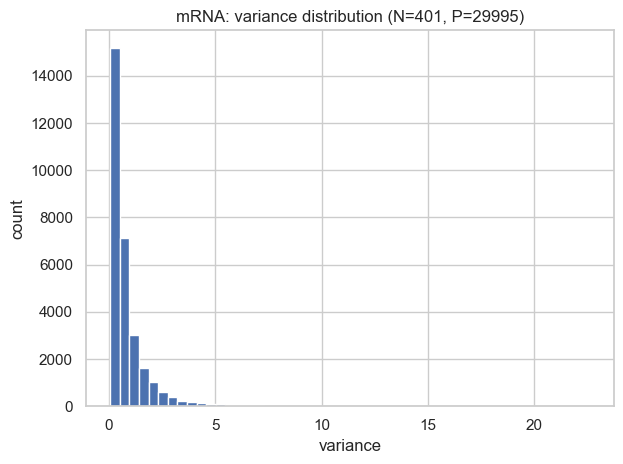

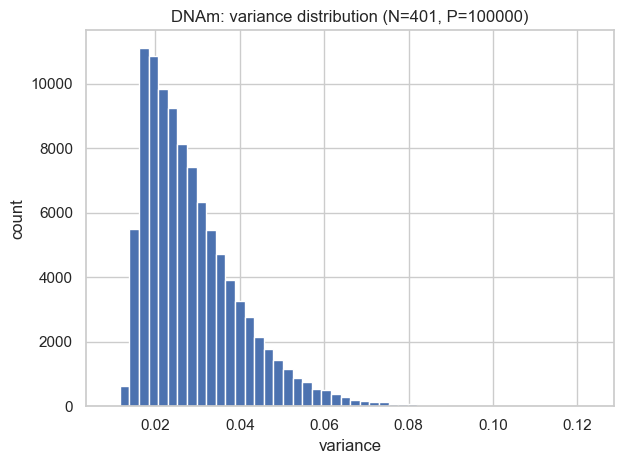

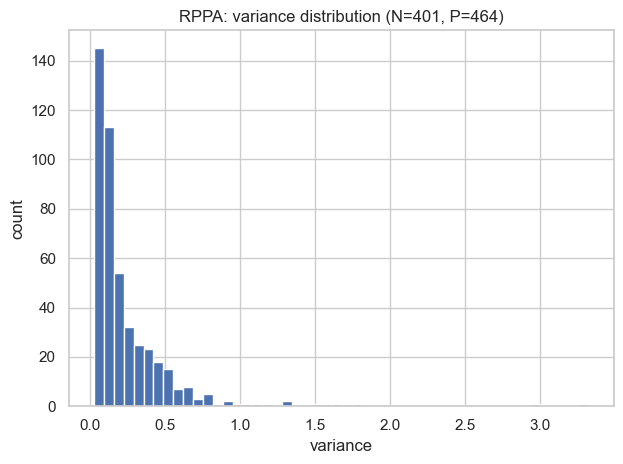

In [11]:
# Per-feature variance per view
var_mrna = per_feature_variance_np(X_mrna, "mRNA", plot=True)
var_meth = per_feature_variance_np(X_meth, "DNAm", plot=True)
var_prot = per_feature_variance_np(X_prot, "RPPA", plot=True)

In [12]:
# Example: compute stats for each view (intersection cohort)
res_var = {}
res_anova = {}

res_var["mRNA"]  = per_feature_variance_np(X_mrna,  "mRNA", plot=False)
res_var["DNAm"]  = per_feature_variance_np(X_meth,  "DNAm", plot=False)
res_var["RPPA"]  = per_feature_variance_np(X_prot,  "RPPA", plot=False)

res_anova["mRNA"] = per_feature_anova_np(X_mrna, y, "mRNA", plot=False)
res_anova["DNAm"] = per_feature_anova_np(X_meth, y, "DNAm", plot=False)
res_anova["RPPA"] = per_feature_anova_np(X_prot, y, "RPPA", plot=False)


#### For report

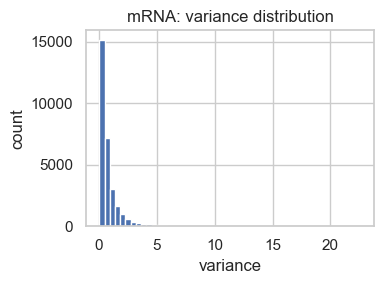

In [13]:
# assuming res_var is already defined and contains "mRNA"
df_var_mrna = res_var["mRNA"]

plt.figure(figsize=(4, 3))
plt.hist(df_var_mrna["var"].values, bins=50)
plt.xlabel("variance")
plt.ylabel("count")
plt.title("mRNA: variance distribution")

plt.tight_layout()
plt.savefig("var_hist_mrna.pdf", dpi=300, bbox_inches="tight")
plt.show()


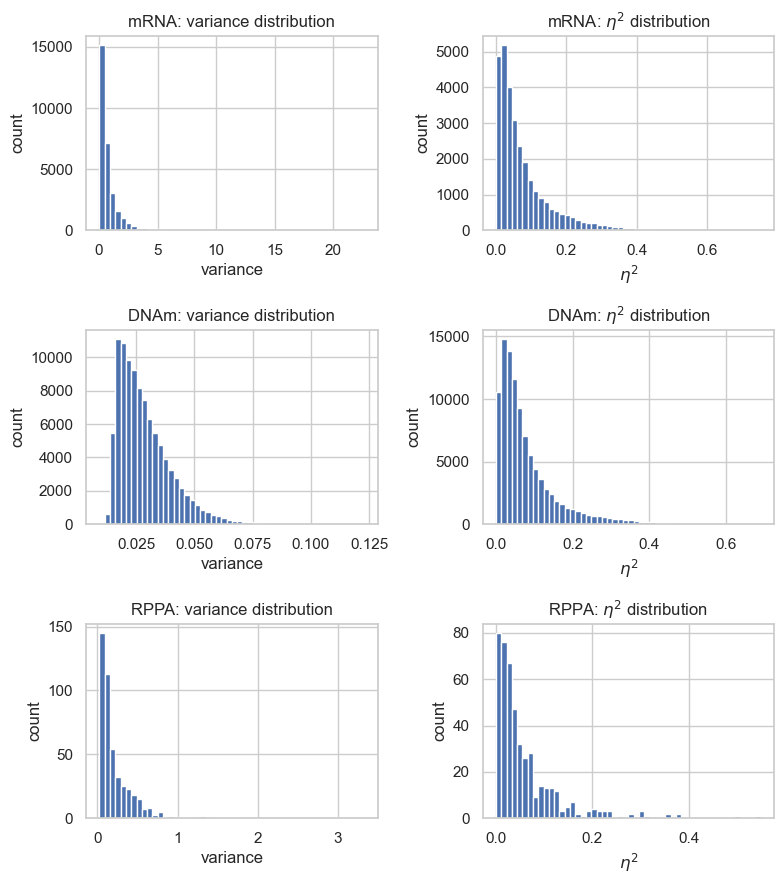

In [14]:
fig, axes = plot_var_eta2_grid(
    res_var,
    res_anova,
    savepath="feature_var_eta2_grid.pdf"   # e.g. for Figure 3
)
plt.show()


### Early integration, ANOVA-based selection

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\Petar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Early integration (ANOVA): best params ===
{'clf__C': 0.01, 'clf__penalty': 'l2'}
Balanced accuracy (CV): 0.859 ± 0.062
ROC-AUC (OvR, weighted) (CV): 0.960 ± 0.014
Log-loss (CV): 0.354 ± 0.073

Test balanced accuracy: 0.823
Test ROC-AUC (OvR, weighted): 0.933

Classification report (test):
              precision    recall  f1-score   support

       Basal      0.923     1.000     0.960        12
        Her2      1.000     0.833     0.909         6
        LumA      0.851     0.870     0.860        46
        LumB      0.625     0.588     0.606        17

    accuracy                          0.827        81
   macro avg      0.850     0.823     0.834        81
weighted avg      0.825     0.827     0.825        81



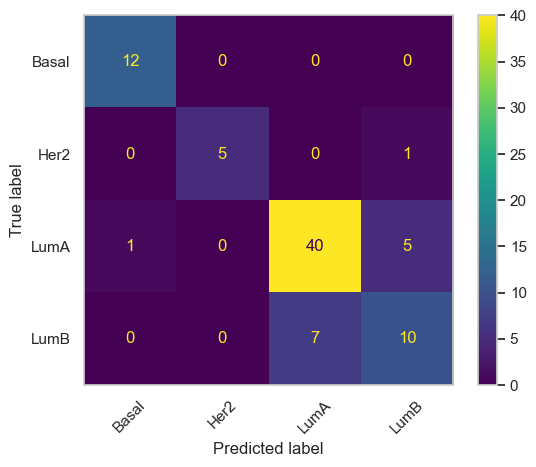

In [15]:
P1, P2, P3 = X_mrna.shape[1], X_meth.shape[1], X_prot.shape[1]
idx_mrna = list(range(0, P1))
idx_meth = list(range(P1, P1 + P2))
idx_prot = list(range(P1 + P2, P1 + P2 + P3))

# example K thresholds from eta^2 stats (or set manually)
K1_eta, K2_eta, K3_eta = 500, 500, P3   # adapt if you want
K_MRNA = min(K1_eta, P1)
K_METH = min(K2_eta, P2)
K_PROT = min(K3_eta, P3)

pre_anova = ColumnTransformer(
    transformers=[
        ("mrna", view_block_anova(K_MRNA), idx_mrna),
        ("meth", view_block_anova(K_METH), idx_meth),
        ("prot", view_block_anova(K_PROT), idx_prot),
    ],
    remainder="drop",
)

ef_anova = Pipeline(
    steps=[
        ("pre", pre_anova),
        (
            "clf",
            LogisticRegression(
                solver="saga",
                multi_class="multinomial",
                max_iter=5000,
                n_jobs=-1,
                random_state=RANDOM_STATE,
                class_weight="balanced",
            ),
        ),
    ]
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
param_grid_ef = {
    "clf__C": [0.01, 0.1, 1, 10, 100],
    "clf__penalty": ["l1", "l2"],
}

gs_ef_anova, y_pred_ef_anova, proba_ef_anova = run_gridsearch_and_report(
    name="Early integration (ANOVA)",
    pipeline=ef_anova,
    param_grid=param_grid_ef,
    Xtr=Xtr_c,
    y_tr=y_tr,
    Xte=Xte_c,
    y_te=y_te,
    cv=cv,
    class_names=class_names
)


### Early integration, variance-based selection

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\Petar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Early integration (variance): best params ===
{'clf__C': 0.01, 'clf__penalty': 'l2'}
Balanced accuracy (CV): 0.842 ± 0.064
ROC-AUC (OvR, weighted) (CV): 0.950 ± 0.021
Log-loss (CV): 0.385 ± 0.086

Test balanced accuracy: 0.765
Test ROC-AUC (OvR, weighted): 0.933

Classification report (test):
              precision    recall  f1-score   support

       Basal      0.923     1.000     0.960        12
        Her2      1.000     0.500     0.667         6
        LumA      0.857     0.913     0.884        46
        LumB      0.688     0.647     0.667        17

    accuracy                          0.840        81
   macro avg      0.867     0.765     0.794        81
weighted avg      0.842     0.840     0.834        81



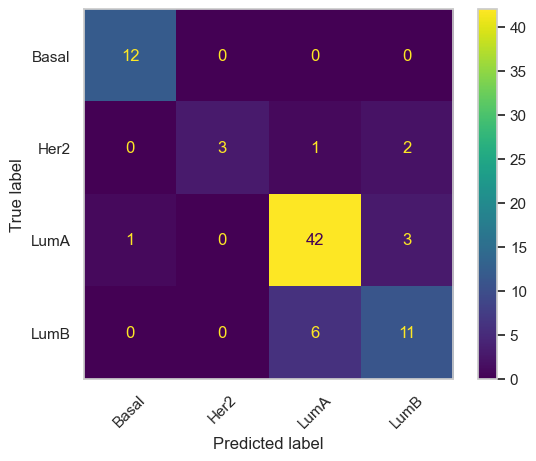

In [16]:
pre_var = ColumnTransformer(
    transformers=[
        ("mrna", view_block_mostVar(K_MRNA), idx_mrna),
        ("meth", view_block_mostVar(K_METH), idx_meth),
        ("prot", view_block_mostVar(K_PROT), idx_prot),
    ],
    remainder="drop",
)

ef_var = Pipeline(
    steps=[
        ("pre", pre_var),
        (
            "clf",
            LogisticRegression(
                solver="saga",
                multi_class="multinomial",
                max_iter=5000,
                n_jobs=-1,
                random_state=RANDOM_STATE,
                class_weight="balanced",
            ),
        ),
    ]
)

gs_ef_var, y_pred_ef_var, proba_ef_var = run_gridsearch_and_report(
    name="Early integration (variance)",
    pipeline=ef_var,
    param_grid=param_grid_ef,
    Xtr=Xtr_c,
    y_tr=y_tr,
    Xte=Xte_c,
    y_te=y_te,
    cv=cv,
    class_names= class_names
)


### Late integration (ANOVA vs variance)

=== Late fusion (ANOVA selection + grid search) ===


C:\Users\Petar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Petar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Petar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Petar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in versio

Late fusion CV balanced accuracy: 0.862 ± 0.047
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\Petar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Best params for mRNA: {'clf__C': 0.01, 'clf__penalty': 'l2'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\Petar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Best params for DNAm: {'clf__C': 0.1, 'clf__penalty': 'l2'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\Petar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Best params for RPPA: {'clf__C': 0.1, 'clf__penalty': 'l1'}

Late fusion test balanced accuracy: 0.828

Classification report (test, late fusion):
              precision    recall  f1-score   support

       Basal      1.000     1.000     1.000        12
        Her2      1.000     0.833     0.909         6
        LumA      0.854     0.891     0.872        46
        LumB      0.625     0.588     0.606        17

    accuracy                          0.840        81
   macro avg      0.870     0.828     0.847        81
weighted avg      0.838     0.840     0.838        81



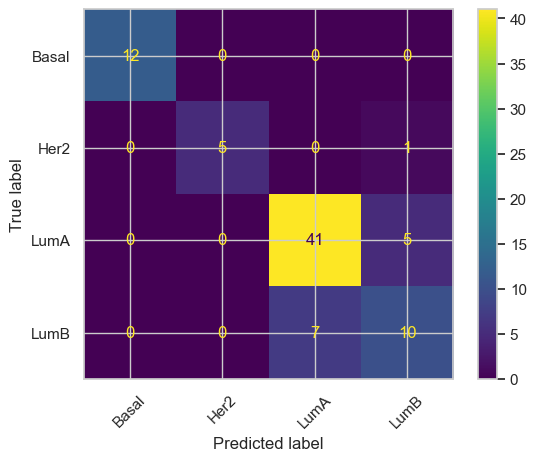


=== Late fusion (variance selection + grid search) ===


C:\Users\Petar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Petar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Petar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Petar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in versio

Late fusion CV balanced accuracy: 0.845 ± 0.041
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\Petar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Best params for mRNA: {'clf__C': 10, 'clf__penalty': 'l1'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\Petar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Best params for DNAm: {'clf__C': 0.01, 'clf__penalty': 'l2'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\Petar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Best params for RPPA: {'clf__C': 0.1, 'clf__penalty': 'l1'}

Late fusion test balanced accuracy: 0.691

Classification report (test, late fusion):
              precision    recall  f1-score   support

       Basal      1.000     0.917     0.957        12
        Her2      0.667     0.667     0.667         6
        LumA      0.776     0.826     0.800        46
        LumB      0.400     0.353     0.375        17

    accuracy                          0.728        81
   macro avg      0.711     0.691     0.700        81
weighted avg      0.722     0.728     0.724        81



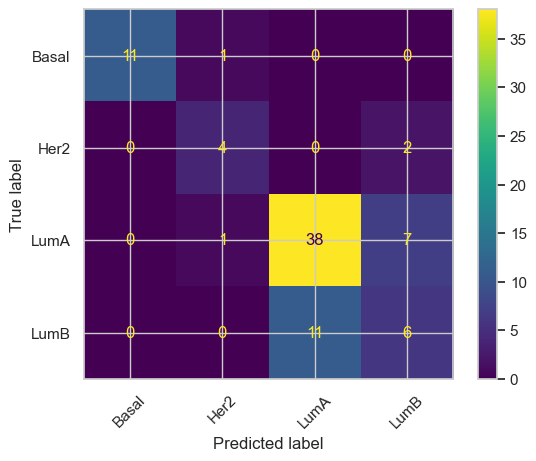

In [17]:
Xtr_views = {"mRNA": Xtr_m, "DNAm": Xtr_d, "RPPA": Xtr_p}
Xte_views = {"mRNA": Xte_m, "DNAm": Xte_d, "RPPA": Xte_p}
k_per_view = {"mRNA": K_MRNA, "DNAm": K_METH, "RPPA": K_PROT}

cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("=== Late fusion (ANOVA selection + grid search) ===")
y_pred_lf_anova, cv_scores_lf_anova = late_fusion_logreg(
    Xtr_views,
    Xte_views,
    y_tr,
    y_te,
    k_per_view=k_per_view,
    cv_outer=cv_outer,
    param_grid=param_grid_ef,
    class_names=class_names,
    use_variance=False,
    

)

print("\n=== Late fusion (variance selection + grid search) ===")
y_pred_lf_var, cv_scores_lf_var = late_fusion_logreg(
    Xtr_views,
    Xte_views,
    y_tr,
    y_te,
    k_per_view=k_per_view,
    cv_outer=cv_outer,
    param_grid=param_grid_ef,
    class_names= class_names,
    use_variance=True,

)
